In [1]:
import numpy as np
from scipy.optimize import fmin_cg
from scipy import linalg as la
from matplotlib import pyplot as plt
from scipy.special import expit
from scipy.stats import binom
import scipy.misc as misc
from sklearn.preprocessing import scale
%matplotlib inline

In [2]:
def grad_lb(X, y, beta, m):
    '''
    This function calculates the gradient of the negative log-likelihood for the
    given values.
    Here, we assume the regression model y_i ~ Binomial(m_i, w_i), where y_i is an 
    integer number of "successes", m_i is the number of trials for the ith case, 
    and w_i is a regression on a feature vector x_i given by the inverse logit transform
    
    X: An m x n array of features
    beta: An n vector of the current "solution" to the system
    y: An m vector of the number of successes, where y_i is the integer number of success for 
        a given trial. (Note that for our wdbc data, this is only 1 or 0)
    m: An m a vector of the number of trials (where m_i is the number of trials for the ith case)
        (Note that for our wdbc data, this is simply a vector of ones)
    '''
    
    Xbeta = np.dot(X, beta)
    # Takes the logistic function of Xbeta (inverse logit transform)
    w = expit(Xbeta)
    # Calculate m_i * w_i - y_i using broadcasting
    mw_yX = (m * w - y).reshape(y.shape[0],1) * X
    # sum (m_iw_i - y_i)X over the rows
    gradlb = mw_yX.sum(axis=0)
    return gradlb

In [3]:
def loglike(X, y, beta, m):
    '''
    This function computes the negative log likelihood given features X, successes y,
    trials m and solution vector beta.
    '''
    Xbeta = np.dot(X, beta)
    w = expit(Xbeta)
    # Use scipy's binomial object to compute the log of the pmf, then take the sum   
    return binom.logpmf(y, m, w).sum()

In [4]:
def gradient_descent(X, y, beta, m, stepsize=1e-4, tol=1e-10, iters=1000):
    '''
    This function performs a simple gradient descent method to find the beta
    that minimizes the negative log likelihood function.
    
    Inputs:
    X: an m by n array of features
    y: an m vector of successes
    beta: an initial guess for the minimizer (for which we are solving)
    m: an m vector of the number of trials
    stepsize: a float, optional to specify the size of each gradient step
    tol: a float, optional to specify the error size used to indicate convergence
    iters; an integer, optional to specify the max number of iterations for the
         algorithm
         
    Returns:
    beta0: the minimizer of the negative log-likelihood
    err: a list of the error between log-likelihoods for each time step
    betas: a list of the new beta for each time step
    ll: a list of the log likelihoods for each time step
    '''
    beta0 = beta
    err = [] # Stores the "error" at each step
    betas = [] # Stores the new value of beta at each step
    ll = [] # Stores the new negative log likelihood at each step
    for i in np.arange(iters):
        #gradlb.append(grad_lb(X, y, beta0, m))
        betas.append(beta0)
        ll.append(-loglike(X, y, beta0, m))
        beta1 = beta0 - stepsize * grad_lb(X, y, beta0, m)
        err.append(np.abs(loglike(X,y,beta1,m) - loglike(X,y,beta0,m)))
        
        #if np.abs(beta1 - beta0).sum() > tol:
        if np.abs(loglike(X,y,beta1,m) - loglike(X,y,beta0,m)) > tol:
            beta0 = beta1            
        else:
            print i, "iterations" # Print the number of iterations.
            return beta1, err, betas, ll 
    return beta0, err, betas, ll
        
        



In [8]:
# Generate some random data with a form similar to the data given
m = 500
n = 11
# Make sure that the first column of X is all ones to handle the intercept term
X = np.hstack((np.ones((m,1)),np.random.rand(m,n)))
# Set y to be a random vector of ones and zeros
y = (np.random.rand(m) > .5).astype(float)
# Let m be a vector of single trials
m = np.ones(m)

In [9]:
# Generate random initial guess vectors
b1 = np.random.rand(n+1)
b2 = np.random.rand(n+1)
b3 = np.random.rand(n+1)

2610 iterations


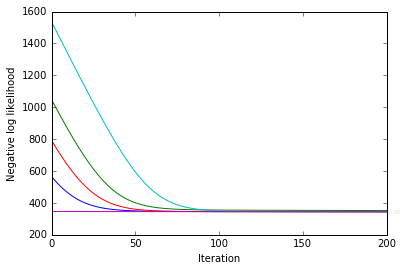

In [10]:
# Demonstrate convergence of the log likelihood for different initial values of beta
for i in [b1,b2,b3, np.ones(n+1), np.zeros(n+1)]:
    beta0, err, betas, ll = gradient_descent(X,y,i,m, tol=1e-4, iters=3000, stepsize=.0001)
    plt.plot(ll)
plt.xlim(0, 200)
plt.xlabel("Iteration")
plt.ylabel("Negative log likelihood")
plt.show()

5641 iterations


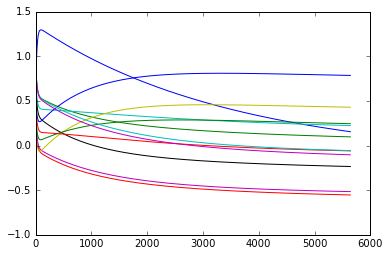

In [25]:
# Demonstrate convergence of the beta values
# Note that for the betas to seemingly converge, we need a higher number of iterations
beta0, err, betas, ll = gradient_descent(X,y,b1,m, tol=1e-4, iters=8000, stepsize=.0001)
plt.plot(betas)
plt.show()

7067 iterations
7219 iterations
7152 iterations
7152 iterations
7153 iterations


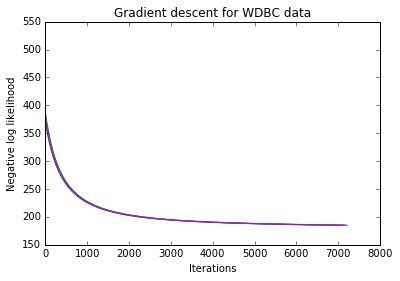

In [28]:
# Exercise 2, B
# Code up a method to fit a logistic regression model by gradient descent

# Load in columns 3-12 of the wdbc data
X = np.loadtxt('wdbc.csv', dtype='float', delimiter=',', usecols=np.arange(3,13))
X1 = scale(X, axis=1)
X = np.hstack((np.ones((X.shape[0],1)), X1))
cl = np.loadtxt('wdbc.csv', dtype='str', delimiter=',', usecols=[1])
# Set Malignant to be 1 and Benign to be 0
y = (cl == 'M').astype(float)
M = np.ones(y.shape[0])
m,n = X.shape
b1 = np.random.rand(n)
b2 = np.random.rand(n) 
b3 = np.random.rand(n) 

for i in [b1,b2,b3, np.ones(n), np.zeros(n)]:
    beta0, err, betas, ll = gradient_descent(X,y,i,M, stepsize=.001, tol=.001, iters=10000)
    plt.plot(ll)
plt.xlabel("Iterations")
plt.ylabel("Negative log likelihood")
plt.title("Gradient descent for WDBC data")
plt.show()

It is interesting to note that for our WDBC data, the algorithm converged in around 7150 iterations for various initial beta vegots, following a very similar convergence pattern. We did not see such initial similarity as strongly for a random X vector